api로 단지코드 가져오기


In [1]:
### api로 단지코드 가져오기
import requests
import xmltodict
import json

# sido_code: {'대구':'27','인천':'28','광주':'29','대전':'30','울산':'31','경기':'41','강원':'42','충북':'43','충남':'44','전북':'45','전남':'46','경북':'47','경남':'48','제주':'50'}
# input_danji_name
def apt_danji(sido,name):
    service_dkey = 'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA=='
    url = 'http://apis.data.go.kr/1613000/AptListService2/getSidoAptList'
    param = {'serviceKey':service_dkey, 'sidoCode':sido, 'pageNo':1, 'numOfRows':'1'}
    r = requests.get(url,params=param)
    
    xmlData = r.content.decode('utf-8')
    parseData = xmltodict.parse(xmlData)
    jData = json.loads(json.dumps(parseData))
    
    rows=jData['response']['body']['totalCount']
    
    pages = int(int(rows)/100)+1    
    row_cnt=1
    for i in range(1, pages+1):
        params={'serviceKey':service_dkey, 'sidoCode':sido, 'pageNo':i, 'numOfRows':'100'}
        
        response = requests.get(url, params=params)
        xml_data = response.content.decode('utf-8')
        parse_data = xmltodict.parse(xml_data)
        
        ord_data = parse_data['response']['body']['items']['item']
        
        try:
            jdata = json.loads(json.dumps(ord_data))
            input_danji_name=name
            
            for code_data in jdata:
                danji_code=code_data['kaptCode']
                danji_name=code_data['kaptName']
                row_cnt += 1
                if danji_name == input_danji_name:
                    # print(code_data)
                    return danji_code
                
        except Exception as e:
            print(f'Error: {e}\n')
            break
            
sido_code=29    
apt_danji(sido_code,"삼각그린타운")

'A50079001'

In [2]:
# # k-apt api로 예측
# # 1. 같은 아파트 개별 관리비 월별 변화 추세 파악
# # 2. 변화 추세에 사용자 데이터 대입??

In [48]:
import requests
from datetime import datetime
from dateutil.relativedelta import *


### api로 단지별 세대수 불러오기
def danji_people(code):
    url = 'http://apis.data.go.kr/1613000/AptBasisInfoService1/getAphusBassInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code}
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['kaptdaCnt']

### api로 단지별 전기 사용량 불러오기
def danji_elect(code,date):
    url = 'http://apis.data.go.kr/1611000/AptIndvdlzManageCostService/getHsmpElectricityCostInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code, 'searchDate' : str(date) }
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['electP']

### api로 단지별 수도 사용량 불러오기
def danji_water(code,date):
    url = 'http://apis.data.go.kr/1611000/AptIndvdlzManageCostService/getHsmpWaterCostInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code, 'searchDate' : str(date) }
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['waterCoolP']

In [60]:
danji_elect_price_list=[]
danji_water_price_list=[]

months_list=[]
present_date = datetime.today().strftime("%Y%m")

# 단지 평균 전기료 조회
for i in range(3,16):
    # 현재 달로부터 3개월 전부터 조회가능
    ago_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-(18-i))).strftime("%Y%m")
    electP = danji_elect(apt_danji(sido_code,"삼각그린타운"),ago_month) # 우리단지 총액
    danji_elect_price = round(int(electP)/int(danji_people(apt_danji(sido_code,"삼각그린타운"))))
    print("우리 단지",ago_month,"평균 전기료:",danji_elect_price)
    danji_elect_price_list.append(danji_elect_price)
    months_list.append(ago_month)

print('\n')
# 단지 평균 수도료 조회
for i in range(3,16):
    # 현재 달로부터 3개월 전부터 조회가능
    ago_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-(18-i))).strftime("%Y%m")
    waterP = danji_water(apt_danji(sido_code,"삼각그린타운"),ago_month) # 우리단지 총액
    danji_water_price = round(int(waterP)/int(danji_people(apt_danji(sido_code,"삼각그린타운"))))
    print("우리 단지",ago_month,"평균 수도료:",danji_water_price)
    danji_water_price_list.append(danji_water_price)

우리 단지 202101 평균 전기료: 35848
우리 단지 202102 평균 전기료: 33813
우리 단지 202103 평균 전기료: 26433
우리 단지 202104 평균 전기료: 27998
우리 단지 202105 평균 전기료: 23288
우리 단지 202106 평균 전기료: 28958
우리 단지 202107 평균 전기료: 28316
우리 단지 202108 평균 전기료: 41323
우리 단지 202109 평균 전기료: 34233
우리 단지 202110 평균 전기료: 25080
우리 단지 202111 평균 전기료: 31398
우리 단지 202112 평균 전기료: 30036
우리 단지 202201 평균 전기료: 34942


우리 단지 202101 평균 수도료: 16806
우리 단지 202102 평균 수도료: 18125
우리 단지 202103 평균 수도료: 17986
우리 단지 202104 평균 수도료: 15827
우리 단지 202105 평균 수도료: 17837
우리 단지 202106 평균 수도료: 16645
우리 단지 202107 평균 수도료: 20049
우리 단지 202108 평균 수도료: 18598
우리 단지 202109 평균 수도료: 19099
우리 단지 202110 평균 수도료: 21459
우리 단지 202111 평균 수도료: 17467
우리 단지 202112 평균 수도료: 19366
우리 단지 202201 평균 수도료: 17203


# k-apt api를 이용한 관리비 예측 구현

RBF 202203 월 예측 전기료: [34630.99925798]
RBF 202203 월 예측 수도료: [16683.85900436]


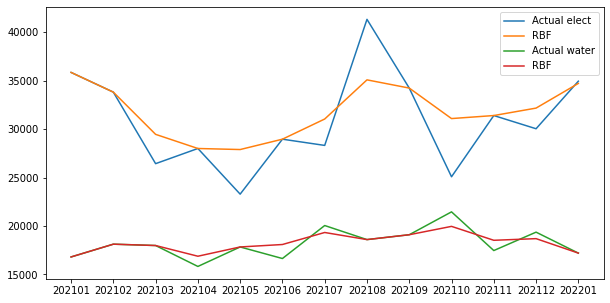

In [62]:
### 13달 데이터로 예측
# Radial Basis Function(RBF)커널을 사용한 SVM(서포트 백터 머신)으로 예측 알고리즘 구현

from sklearn.svm import SVR
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

months=[]
j=1

for j in range(len(danji_elect_price_list)):
    months.append([int(j+1)])
    j=j+1

# C가 낮을수록 일반적인 결정, 높을수록 이상치의 존재 가능성 작게 봐서 세심한 결정(너무 낮거나 높으면 과소, 과대적합될 수 있음)
# gamma는 하나의 데이터 샘플이 영향력을 행사하는 거리 결정, 값이 클수록 작은 표준편차 가짐
rbf_svr_e = SVR(kernel='rbf', C=5000, gamma=0.5)
rbf_svr_w = SVR(kernel='rbf', C=5000, gamma=0.5)

rbf_svr_e.fit(months, danji_elect_price_list)
rbf_svr_w.fit(months, danji_water_price_list)

nextMonth = [[len(months)+1]]

n_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-1)).strftime("%Y%m")
print('RBF',n_month,"월 예측 전기료:",rbf_svr_e.predict(nextMonth))
print('RBF',n_month,"월 예측 수도료:",rbf_svr_w.predict(nextMonth))


plt.figure(figsize=(10,5))
plt.plot(months_list, danji_elect_price_list ,label='Actual elect')
plt.plot(months_list, rbf_svr_e.predict(months),label='RBF')
plt.plot(months_list, danji_water_price_list, label='Actual water')
plt.plot(months_list, rbf_svr_w.predict(months), label='RBF')

plt.legend()
plt.show()


### 사용자 데이터에 대입 해야함

# pyplot을 이용한 사용자 에너지 소비(금액) 데이터 시각화

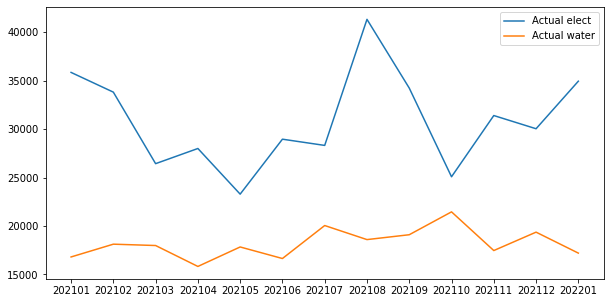

In [65]:
plt.figure(figsize=(10,5))

plt.plot(months_list, danji_elect_price_list ,label='Actual elect')
plt.plot(months_list, danji_water_price_list, label='Actual water')

plt.legend()
plt.show()